# NN5: Testowanie różnych funkcji aktywacji

#### Magdalena Jeczeń

Wczytywanie danych

In [294]:
import numpy as np
import pandas as pd
data = pd.read_csv('./mio1/classification/rings3-regular-training.csv')
X_train_r3_r = np.array([data.x, data.y]).transpose()
y_train_r3_r = np.array(data.c)
data = pd.read_csv('./mio1/classification/rings3-regular-test.csv')
X_test_r3_r = np.array([data.x, data.y]).transpose()
y_test_r3_r = np.array(data.c)
data = pd.read_csv('./mio1/classification/rings5-regular-training.csv')
X_train_r5_r= np.array([data.x, data.y]).transpose()
y_train_r5_r = np.array(data.c)
data = pd.read_csv('./mio1/classification/rings5-regular-test.csv')
X_test_r5_r= np.array([data.x, data.y]).transpose()
y_test_r5_r = np.array(data.c)
data = pd.read_csv('./mio1/regression/steps-large-training.csv')
X_train_st_l = np.array(data.x)
y_train_st_l = np.array(data.y)
data = pd.read_csv('./mio1/regression/steps-large-test.csv')
X_test_st_l = np.array(data.x)
y_test_st_l = np.array(data.y)
data = pd.read_csv('./mio1/regression/multimodal-large-training.csv')
X_train_mm_l = np.array(data.x)
y_train_mm_l = np.array(data.y)
data = pd.read_csv('./mio1/regression/multimodal-large-test.csv')
X_test_mm_l = np.array(data.x)
y_test_mm_l = np.array(data.y)

inne funkcje


In [71]:
def one_hot_encoding(y):
    unique_classes = np.unique(y)
    y_encoded = np.zeros((len(y), len(unique_classes)))

    for i, c in enumerate(y):
        j = np.where(unique_classes == c)[0][0]
        y_encoded[i, j] = 1

    return y_encoded

In [72]:
def one_hot_decoding(y_encoded):
    num_classes = y_encoded.shape[1]
    decoded_values = np.zeros(y_encoded.shape[0], dtype=int)
    for i, encoded_row in enumerate(y_encoded):
        index = np.where(encoded_row == 1)[0][0]
        decoded_values[i] = index

    return decoded_values


In [73]:
import matplotlib.pyplot as plt
def plot_scatter_with_classes(X, y):

    classes = np.unique(y)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  
    
    for idx, class_label in enumerate(classes):
        class_data = X[y == class_label]
        plt.scatter(class_data[:, 0], class_data[:, 1], color=colors[idx % len(colors)], label=f'Class {class_label}')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Scatter Plot with Classes')
    plt.legend()
    plt.grid(True)
    plt.show()

In [159]:
def plot_multiple_costs(costs_list, title):
    plt.figure(figsize=(10, 6))
    
    for cost_df, label in costs_list:
        plt.plot(cost_df['Epoch'], cost_df['Cost_Train'], label=label)

    plt.xlabel('Epoch')
    plt.ylabel('Cost Train')
    plt.title(title)
    plt.legend()
    plt.show()

In [160]:
def plot_multiple_costs_log(costs_list,title):
    plt.figure(figsize=(10, 6))
    
    for cost_df, label in costs_list:
        plt.plot(cost_df['Epoch'], cost_df['Cost_Train'], label=label)

    plt.xlabel('Epoch')
    plt.ylabel('Cost Train')
    plt.title(title)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.legend()
    plt.show()

In [76]:
def make_df_of_costs(cost_history):
    return pd.DataFrame(cost_history, columns=['Epoch', 'Cost_Train'])

In [295]:
y_train_r3_r_enc = one_hot_encoding(y_train_r3_r)
y_test_r3_r_enc = one_hot_encoding(y_test_r3_r)
y_train_r5_r_enc = one_hot_encoding(y_train_r5_r)
y_test_r5_r_enc = one_hot_encoding(y_test_r5_r)

Sieć neuronowa

In [243]:
class Network(object):
    def __init__(self, layers_sizes, activation_function_type, problem = "regression", last_layer_function = "linear"):
        self.problem = problem
        self.last_layer_function = last_layer_function
        
        self.weights = None
        self.biases = None
        self.weights_0 = None
        self.biases_0 = None
        
        self.means_X = []
        self.means_Y = []
        self.stds_Y = []
        self.stds_X = []
        
        self.mean_X = None
        self.mean_Y = None
        self.std_Y = None
        self.std_X = None
        
        self.sizes_in = layers_sizes[:-1]
        self.sizes_out = layers_sizes[1:]
        
        self.a = None
        self.z = None
        
        self.activation_function_type = activation_function_type
        
        self.mse_train = None
        
        self.cost_history = []
        
        self.velocity_weight = None
        self.velocity_bias = None
        
        self.mean_square_weight = None
        self.mean_square_bias = None
        
    def __activation_function(self, x):
        if self.activation_function_type == "sigmoid":
            return 1.0 / (1.0 + np.exp(-x))
        elif self.activation_function_type == "tanh":
            return np.tanh(x)
        elif self.activation_function_type == "relu":
            return np.maximum(0, x)
        elif self.activation_function_type == "linear":
            return x

    def __activation_function_derivative(self, x):
        if self.activation_function_type == "sigmoid":
            return self.__activation_function(np.array(x)) * (1-self.__activation_function(np.array(x)))
        elif self.activation_function_type == "tanh":
            return 1 - np.square(np.tanh(x))
        elif self.activation_function_type == "relu":
            return np.where(x > 0, 1, 0)
        elif self.activation_function_type == "linear":
            #print(np.ones_like(x).shape)
            return np.ones(x.shape)
    
    def __last_layer_funcion(self, x):
        if self.last_layer_function == "linear":
            return x
        elif self.last_layer_function == "sigmoid":
            return 1.0 / (1.0 + np.exp(-x))
        elif self.last_layer_function == "softmax":
            l = np.exp(x)
            m = np.sum(l,axis = 1, keepdims=True)
            s = l/m
            return s
        
    
    
    def generate_weights(self, method = 'uniform'):
        if method == 'uniform':
            self.weights_0 = [np.random.rand(size_in,size_out) for (size_in,size_out) in zip(self.sizes_in,self.sizes_out)]
        if method == 'he':
            self.weights_0 = [np.random.normal(0,np.sqrt(2/(insi+outi)),size = (insi,outi)) for (insi,outi) in zip(self.sizes_in,self.sizes_out)]
            
        self.weights = self.weights_0.copy()
        
        self.z = [None]*len(self.weights)
        self.a = [None]*len(self.weights)
            
    def generate_biases(self, method = 'zeros'):
        if method == 'zeros':
            self.biases_0 = [np.zeros(size_out) for size_out in self.sizes_out]
            
        self.biases = self.biases_0.copy()
        
    def set_custom_weights(self, custom_weights):
        self.weights_0 = custom_weights.copy()
        self.weights = self.weights_0.copy()   
        self.z = [None]*len(self.weights)
        self.a = [None]*len(self.weights)
    
    def get_normalization_parameters(self,X,Y):
        if self.problem == "classification":
            for i in range(X.shape[1]):
                mean = np.mean(X[:,i])
                std = np.std(X[:,i])
                self.means_X.append(mean)
                self.stds_X.append(std)
            
        elif self.problem == "regression":
            self.mean_X = np.mean(X)
            self.std_X = np.std(X)
            self.mean_Y = np.mean(Y)
            self.std_Y = np.std(Y)
            
        
    def normalize_X(self,X):
        if self.problem == "classification":
            X_norm = X.copy()
            for i in range(X.shape[1]):
                X_norm[:,i] = (X[:,i] - self.means_X[i])/self.stds_X[i]
                return X_norm
        elif self.problem == "regression":
            return (X - self.mean_X) / self.std_X
        
    
    def denormalize_Y(self, Y_pred):
        return Y_pred*self.std_Y + self.mean_Y
    
    def feedforward(self, X):
        #print("X: ", X)
        if self.problem == "regression":
            layer = np.row_stack(self.normalize_X(X))
        #layer = np.row_stack(self.normalize_X(X))
        elif self.problem == "classification":
            layer = self.normalize_X(X)
        #print("layer ( X normalized ): ", layer)
        self.z[0] = layer
        for i in range(len(self.weights) - 1):
            self.a[i] = layer
            layer = layer@self.weights[i] + self.biases[i]
            self.z[i+1] = layer
            layer = self.__activation_function(layer)
            #print("czy tu blad")
    
    
        self.a[-1] = layer
        Y_pred = None 
        
        if self.problem == "classification":
            Y_pred = self.__last_layer_funcion(layer@self.weights[len(self.weights) - 1]+self.biases[len(self.weights) - 1])
        
        elif self.problem == "regression":
            Y_pred_normalized = (layer@self.weights[len(self.weights) - 1] + self.biases[len(self.weights) - 1])
            Y_pred_denormalized = self.denormalize_Y(np.hstack(Y_pred_normalized))
            Y_pred = Y_pred_denormalized
        
        return Y_pred
    
    def MSE(self, X, Y):
        return np.mean((self.feedforward(X) - Y) ** 2)
    
    
    def Fscore(self, X, Y):
        y_pred = self.feedforward(X)
        classes = np.argmax(y_pred, axis=1)
        y_pred_one_hot = np.zeros(Y.shape)
        y_pred_one_hot[np.arange(len(y_pred_one_hot)), classes] = 1
        y_pred_one_hot = y_pred_one_hot.astype(int).transpose()
        Y = Y.astype(int).transpose()
        result = np.zeros(len(Y))
        for i in range(len(Y)):
            tp = np.count_nonzero(y_pred_one_hot[i] & Y[i])  
            fp = np.count_nonzero(y_pred_one_hot[i] & (1 - Y[i]))  
            fn = np.count_nonzero((1 - y_pred_one_hot[i]) & Y[i])  
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            if precision + recall == 0:
                result[i] = 0
            else:
                result[i] = 2 * (precision * recall) / (precision + recall)
        return result
    
    
    def FScore_mean(self, Fscore):
        return np.mean(Fscore)
    
    def backprop(self,X,Y):
        n = len(self.weights)
        delta_b = [np.zeros(b.shape) for b in self.biases]
        delta_w = [np.zeros(w.shape) for w in self.weights]
        delta = None
        if self.problem == "regression":
            delta = np.row_stack((self.feedforward(X)-Y)/len(X))
        elif self.problem == "classification":
            delta = (self.feedforward(X)-Y)/len(X)
        for i in range(1,n+1):
                delta_b[-i] = np.sum(delta,axis = 0)
                delta_w[-i] = (self.a[-i].transpose())@delta
                delta = (delta@(self.weights[-i].transpose()))*self.__activation_function_derivative(self.z[-i])
        return delta_w, delta_b
   
    def Moment(self, delta_w, delta_b, alpha):
        self.velocity_bias = [alpha*prev_vel_bias + db for (prev_vel_bias,db) in zip(self.velocity_bias,delta_b)]
        self.velocity_weight = [alpha*prev_vel_weight + dw for (prev_vel_weight,dw) in zip(self.velocity_weight,delta_w)]
        return self.velocity_weight, self.velocity_bias
   
    def RMSProp(self, delta_w, delta_b, alpha):
        self.mean_square_weight = [alpha*prev_mean_sq_w + (1-alpha)*np.square(dw) for (prev_mean_sq_w,dw) in zip(self.mean_square_weight,delta_w)]
        self.mean_square_bias = [alpha*prev_mean_sq_b + (1-alpha)*np.square(db) for (prev_mean_sq_b,db) in zip(self.mean_square_bias,delta_b)]
        
        delta_w_divided = [np.divide(dw,np.sqrt(mean_sq_w)+0.000001) for (mean_sq_w,dw) in zip(self.mean_square_weight,delta_w)]
        delta_b_divided = [np.divide(db,np.sqrt(mean_sq_b)+0.000001) for (mean_sq_b,db) in zip(self.mean_square_bias,delta_b)]
        return delta_w_divided, delta_b_divided
   
    def train(self,X,Y,batch_size, eta, epochs, method = "gradient", alpha = 0.9, X_test=None, Y_test=None, shuffle = False):
        n = len(X)
        self.get_normalization_parameters(X,Y)
        self.mse_train= [None]*epochs
        
        self.velocity_weight = [np.zeros(w.shape) for w in self.weights]
        self.velocity_bias= [np.zeros(b.shape) for b in self.biases]
        self.mean_square_weight = [np.zeros(w.shape) for w in self.weights]
        self.mean_square_bias = [np.zeros(b.shape) for b in self.biases]
        
        for epoch in range(epochs):
            mini_batches = list(range(n))
            if shuffle:
                np.random.shuffle(mini_batches)
            for i in range(0,n,batch_size):
                mini_batch = mini_batches[i:i+batch_size]
                delta_w, delta_b = self.backprop(X[mini_batch],Y[mini_batch])
                if method == "moment":
                    delta_w, delta_b = self.Moment(delta_w, delta_b, alpha)
                elif method == "RMSProp":
                    delta_w, delta_b = self.RMSProp(delta_w,delta_b,alpha)
                
                self.weights = [w- eta*dw for (w,dw) in zip(self.weights,delta_w)]
                self.biases = [b- eta*db for (b,db) in zip(self.biases,delta_b)] 
            
            if self.problem == "regression":
                mse = self.MSE(X, Y)
                self.cost_history.append((epoch, mse))
                print("Epoch {0} complete, mse: {1}".format(epoch, mse))
                
            
            elif self.problem == "classification":
                Fscore = self.Fscore(X,Y)
                Fscore_mean = self.FScore_mean(Fscore)
                self.cost_history.append((epoch, Fscore_mean))
                print("Epoch {0} complete, Fscore: {1}, Fscore_mean: {2}".format(epoch, Fscore, Fscore_mean))
                
        if self.problem == "regression":
            if X_test is not None and Y_test is not None:
                print("Mse for test: ", self.MSE(X_test, Y_test))
        
        elif self.problem == "classification":
            if X_test is not None and Y_test is not None:
                Fscore_test = self.Fscore(X_test, Y_test)
                print("Fscore for test: {0}, Fscore_mean for test: {1}".format(Fscore_test ,self.FScore_mean(Fscore_test)))
        
            
        return None

### Testy na zbiorze multimodal-large

In [244]:
net_mm_l_sigmoid_l1 = Network([1,10,1], activation_function_type="sigmoid", problem = "regression")
net_mm_l_sigmoid_l1.set_custom_weights([np.array([[0.57846149, 0.30382253, 0.84151341, 0.8552539 , 0.9812935 ,
         0.36641296, 0.81177047, 0.85322962, 0.68341909, 0.01553945]]),
 np.array([[0.23350701],
        [0.94950228],
        [0.55738919],
        [0.25500432],
        [0.8006958 ],
        [0.97099586],
        [0.70792236],
        [0.87218408],
        [0.06180195],
        [0.06057527]])])
net_mm_l_sigmoid_l1.generate_biases("zeros")
net_mm_l_sigmoid_l1.train(X_train_mm_l, y_train_mm_l, 100, 0.001, 500, shuffle=True, X_test = X_test_mm_l, Y_test=y_test_mm_l, method="moment", alpha=0.9)

Epoch 0 complete, mse: 3870.64525523002
Epoch 1 complete, mse: 3361.436502941542
Epoch 2 complete, mse: 2731.390212811754
Epoch 3 complete, mse: 2399.7868374501268
Epoch 4 complete, mse: 2331.9239874262935
Epoch 5 complete, mse: 2306.9023283908755
Epoch 6 complete, mse: 2200.6057707256887
Epoch 7 complete, mse: 2127.765716626466
Epoch 8 complete, mse: 2075.500108742457
Epoch 9 complete, mse: 2034.595960036746
Epoch 10 complete, mse: 1987.42333383082
Epoch 11 complete, mse: 1949.1895975746706
Epoch 12 complete, mse: 1914.9374244621551
Epoch 13 complete, mse: 1952.95652737142
Epoch 14 complete, mse: 1949.9443173999234
Epoch 15 complete, mse: 1840.5597551937499
Epoch 16 complete, mse: 1799.4965868026648
Epoch 17 complete, mse: 1747.8163286833515
Epoch 18 complete, mse: 1708.053424746389
Epoch 19 complete, mse: 1665.4246926838043
Epoch 20 complete, mse: 1662.077756545443
Epoch 21 complete, mse: 1563.1120518665393
Epoch 22 complete, mse: 1503.9398977114215
Epoch 23 complete, mse: 1462.41067

In [124]:
net_mm_l_sigmoid_l1.weights_0

[array([[0.57846149, 0.30382253, 0.84151341, 0.8552539 , 0.9812935 ,
         0.36641296, 0.81177047, 0.85322962, 0.68341909, 0.01553945]]),
 array([[0.23350701],
        [0.94950228],
        [0.55738919],
        [0.25500432],
        [0.8006958 ],
        [0.97099586],
        [0.70792236],
        [0.87218408],
        [0.06180195],
        [0.06057527]])]

In [245]:
net_mm_l_tanh_l1 = Network([1,10,1], activation_function_type="tanh", problem = "regression")
net_mm_l_tanh_l1.set_custom_weights([np.array([[0.57846149, 0.30382253, 0.84151341, 0.8552539 , 0.9812935 ,
         0.36641296, 0.81177047, 0.85322962, 0.68341909, 0.01553945]]),
 np.array([[0.23350701],
        [0.94950228],
        [0.55738919],
        [0.25500432],
        [0.8006958 ],
        [0.97099586],
        [0.70792236],
        [0.87218408],
        [0.06180195],
        [0.06057527]])])
net_mm_l_tanh_l1.generate_biases("zeros")
net_mm_l_tanh_l1.train(X_train_mm_l, y_train_mm_l, 100, 0.001, 500, shuffle=True, X_test = X_test_mm_l, Y_test=y_test_mm_l, method="moment", alpha=0.9)

Epoch 0 complete, mse: 2397.1046260724056
Epoch 1 complete, mse: 2037.8171108992506
Epoch 2 complete, mse: 2124.389941130779
Epoch 3 complete, mse: 1902.4063874238043
Epoch 4 complete, mse: 1886.2108837456726
Epoch 5 complete, mse: 1808.0461276467242
Epoch 6 complete, mse: 1817.1327170473983
Epoch 7 complete, mse: 1803.659230986417
Epoch 8 complete, mse: 1739.322398124604
Epoch 9 complete, mse: 1593.351138298834
Epoch 10 complete, mse: 1458.5151920367987
Epoch 11 complete, mse: 1308.3611368029465
Epoch 12 complete, mse: 1152.92311706947
Epoch 13 complete, mse: 902.47897143337
Epoch 14 complete, mse: 799.2998851609633
Epoch 15 complete, mse: 776.8706084358577
Epoch 16 complete, mse: 710.868458001282
Epoch 17 complete, mse: 703.014465074971
Epoch 18 complete, mse: 635.9942892453606
Epoch 19 complete, mse: 631.0747996661603
Epoch 20 complete, mse: 569.2834011630983
Epoch 21 complete, mse: 550.8735484751023
Epoch 22 complete, mse: 533.0864520378733
Epoch 23 complete, mse: 513.9285129656781

In [246]:
net_mm_l_relu_l1 = Network([1,10,1], activation_function_type="relu", problem = "regression")
net_mm_l_relu_l1.set_custom_weights([np.array([[0.57846149, 0.30382253, 0.84151341, 0.8552539 , 0.9812935 ,
         0.36641296, 0.81177047, 0.85322962, 0.68341909, 0.01553945]]),
 np.array([[0.23350701],
        [0.94950228],
        [0.55738919],
        [0.25500432],
        [0.8006958 ],
        [0.97099586],
        [0.70792236],
        [0.87218408],
        [0.06180195],
        [0.06057527]])])
net_mm_l_relu_l1.generate_biases("zeros")
net_mm_l_relu_l1.train(X_train_mm_l, y_train_mm_l, 100, 0.001, 500, shuffle=True, X_test = X_test_mm_l, Y_test=y_test_mm_l, method="Moment", alpha=0.9)

Epoch 0 complete, mse: 3178.574031097541
Epoch 1 complete, mse: 3124.8720153092936
Epoch 2 complete, mse: 3067.1325146131476
Epoch 3 complete, mse: 3015.538409200861
Epoch 4 complete, mse: 2974.5263647859992
Epoch 5 complete, mse: 2938.7689327432677
Epoch 6 complete, mse: 2939.5619776979515
Epoch 7 complete, mse: 2896.5036569033837
Epoch 8 complete, mse: 2861.8609763100117
Epoch 9 complete, mse: 2867.3031004266827
Epoch 10 complete, mse: 2828.497524714195
Epoch 11 complete, mse: 2817.477872173323
Epoch 12 complete, mse: 2825.941353107215
Epoch 13 complete, mse: 2869.1143454042044
Epoch 14 complete, mse: 2783.411549017035
Epoch 15 complete, mse: 2789.79870427474
Epoch 16 complete, mse: 2772.660312921873
Epoch 17 complete, mse: 2774.8957600091094
Epoch 18 complete, mse: 2762.9259257187678
Epoch 19 complete, mse: 2760.792680161231
Epoch 20 complete, mse: 2807.519085353742
Epoch 21 complete, mse: 2752.7603226311107
Epoch 22 complete, mse: 2754.046631282352
Epoch 23 complete, mse: 2758.3008

In [247]:
net_mm_l_linear_l1 = Network([1,10,1], activation_function_type="linear", problem = "regression")
net_mm_l_linear_l1.set_custom_weights([np.array([[0.57846149, 0.30382253, 0.84151341, 0.8552539 , 0.9812935 ,
         0.36641296, 0.81177047, 0.85322962, 0.68341909, 0.01553945]]),
 np.array([[0.23350701],
        [0.94950228],
        [0.55738919],
        [0.25500432],
        [0.8006958 ],
        [0.97099586],
        [0.70792236],
        [0.87218408],
        [0.06180195],
        [0.06057527]])])
net_mm_l_linear_l1.generate_biases("zeros")
net_mm_l_linear_l1.train(X_train_mm_l, y_train_mm_l, 100, 0.001, 500, shuffle=True, X_test = X_test_mm_l, Y_test=y_test_mm_l, method="moment", alpha=0.9)

Epoch 0 complete, mse: 4532.54232132995
Epoch 1 complete, mse: 4429.674730270508
Epoch 2 complete, mse: 4425.615674678986
Epoch 3 complete, mse: 4440.531441369545
Epoch 4 complete, mse: 4415.619410370713
Epoch 5 complete, mse: 4435.816937985038
Epoch 6 complete, mse: 4399.45459025664
Epoch 7 complete, mse: 4401.42897220052
Epoch 8 complete, mse: 4412.585447073233
Epoch 9 complete, mse: 4535.894170050339
Epoch 10 complete, mse: 4421.710391144649
Epoch 11 complete, mse: 4496.621705323098
Epoch 12 complete, mse: 4408.514576304699
Epoch 13 complete, mse: 4403.739708490001
Epoch 14 complete, mse: 4405.287076873146
Epoch 15 complete, mse: 4408.315962514134
Epoch 16 complete, mse: 4417.985620996531
Epoch 17 complete, mse: 4499.9290829518195
Epoch 18 complete, mse: 4434.474987309959
Epoch 19 complete, mse: 4413.6893328305905
Epoch 20 complete, mse: 4435.588509456021
Epoch 21 complete, mse: 4477.310935935998
Epoch 22 complete, mse: 4409.165712017022
Epoch 23 complete, mse: 4421.968933460982
Epo

In [248]:
sigm_l1 = make_df_of_costs(net_mm_l_sigmoid_l1.cost_history)
tanh_l1 = make_df_of_costs(net_mm_l_tanh_l1.cost_history)
relu_l1 = make_df_of_costs(net_mm_l_relu_l1.cost_history)
linear_l1 = make_df_of_costs(net_mm_l_linear_l1.cost_history)
cost_list = [(sigm_l1, 'sigmoid'), (tanh_l1, 'tanh'),(relu_l1, 'relu'),(linear_l1, 'linear')]

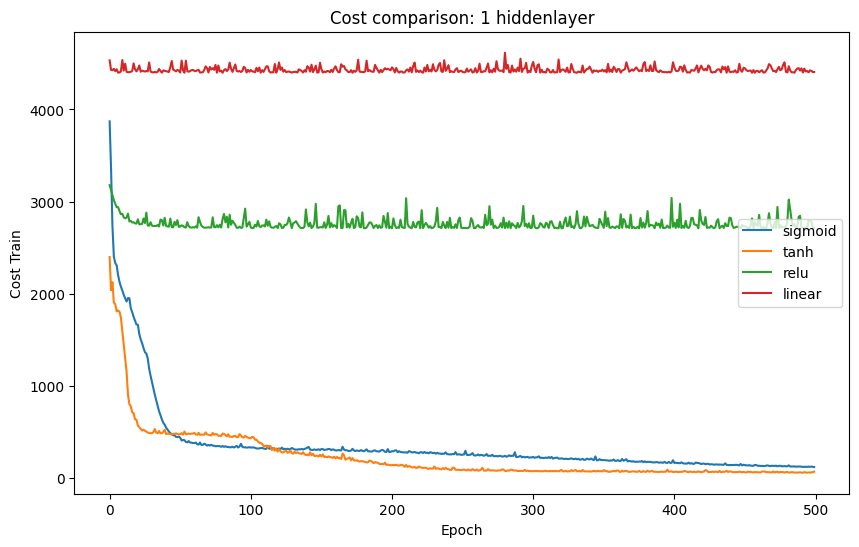

In [305]:
plot_multiple_costs(cost_list, "Cost comparison: 1 hiddenlayer")

### 2 warstwy ukryte

In [251]:
net_mm_l_sigmoid_l2 = Network([1,7,7,1], activation_function_type="sigmoid", problem = "regression")
net_mm_l_sigmoid_l2.generate_weights("uniform")
net_mm_l_sigmoid_l2.generate_biases("zeros")
net_mm_l_sigmoid_l2.train(X_train_mm_l, y_train_mm_l, 100, 0.001, 500, shuffle=True, X_test = X_test_mm_l, Y_test=y_test_mm_l, method="moment", alpha=0.9)

Epoch 0 complete, mse: 4478.970272854776
Epoch 1 complete, mse: 3552.651115244552
Epoch 2 complete, mse: 3359.339238074984
Epoch 3 complete, mse: 3179.845218454933
Epoch 4 complete, mse: 2952.6170383903905
Epoch 5 complete, mse: 2566.170632786374
Epoch 6 complete, mse: 2085.0070027733886
Epoch 7 complete, mse: 1958.878619384329
Epoch 8 complete, mse: 1961.9854925565712
Epoch 9 complete, mse: 1825.2952136968916
Epoch 10 complete, mse: 1774.8948608168614
Epoch 11 complete, mse: 1722.8078491010874
Epoch 12 complete, mse: 1757.1659515680328
Epoch 13 complete, mse: 1658.9906402078059
Epoch 14 complete, mse: 1621.8591508674037
Epoch 15 complete, mse: 1608.2522198022318
Epoch 16 complete, mse: 1579.522876654898
Epoch 17 complete, mse: 1561.3755377317832
Epoch 18 complete, mse: 1547.6218373850636
Epoch 19 complete, mse: 1541.134736513445
Epoch 20 complete, mse: 1517.0991413348552
Epoch 21 complete, mse: 1508.501402822367
Epoch 22 complete, mse: 1494.4123712909823
Epoch 23 complete, mse: 1469.3

In [252]:
net_mm_l_sigmoid_l2.weights_0

[array([[0.47293691, 0.08728238, 0.33387015, 0.34236797, 0.79249311,
         0.06372974, 0.1177014 ]]),
 array([[0.76612638, 0.79730995, 0.15384958, 0.49562273, 0.24411005,
         0.26657998, 0.80847212],
        [0.19018696, 0.20501404, 0.77823299, 0.7424394 , 0.25099496,
         0.09216307, 0.48989735],
        [0.49432043, 0.09411302, 0.61727049, 0.17818405, 0.09281444,
         0.69728748, 0.31343252],
        [0.32927036, 0.59426506, 0.22472824, 0.89750166, 0.86513725,
         0.15179478, 0.29830781],
        [0.17718042, 0.79954032, 0.52216093, 0.78128649, 0.37542208,
         0.76184152, 0.34888424],
        [0.4627485 , 0.67804519, 0.04786317, 0.10368645, 0.55800849,
         0.10539491, 0.97871905],
        [0.9524056 , 0.70304936, 0.36632728, 0.72533485, 0.49717568,
         0.61215466, 0.48086922]]),
 array([[0.39216302],
        [0.92315319],
        [0.95205419],
        [0.29683456],
        [0.37052121],
        [0.94671407],
        [0.61683931]])]

In [312]:
net_mm_l_tanh_l2 = Network([1,7,7,1], activation_function_type="tanh", problem = "regression")
net_mm_l_tanh_l2.set_custom_weights([np.array([[0.47293691, 0.08728238, 0.33387015, 0.34236797, 0.79249311,
         0.06372974, 0.1177014 ]]),
 np.array([[0.76612638, 0.79730995, 0.15384958, 0.49562273, 0.24411005,
         0.26657998, 0.80847212],
        [0.19018696, 0.20501404, 0.77823299, 0.7424394 , 0.25099496,
         0.09216307, 0.48989735],
        [0.49432043, 0.09411302, 0.61727049, 0.17818405, 0.09281444,
         0.69728748, 0.31343252],
        [0.32927036, 0.59426506, 0.22472824, 0.89750166, 0.86513725,
         0.15179478, 0.29830781],
        [0.17718042, 0.79954032, 0.52216093, 0.78128649, 0.37542208,
         0.76184152, 0.34888424],
        [0.4627485 , 0.67804519, 0.04786317, 0.10368645, 0.55800849,
         0.10539491, 0.97871905],
        [0.9524056 , 0.70304936, 0.36632728, 0.72533485, 0.49717568,
         0.61215466, 0.48086922]]),
 np.array([[0.39216302],
        [0.92315319],
        [0.95205419],
        [0.29683456],
        [0.37052121],
        [0.94671407],
        [0.61683931]])])
net_mm_l_tanh_l2.generate_biases("zeros")
net_mm_l_tanh_l2.train(X_train_mm_l, y_train_mm_l, 100, 0.001, 500, shuffle=True, X_test = X_test_mm_l, Y_test=y_test_mm_l, method="moment", alpha=0.9)

Epoch 0 complete, mse: 1714.9174834942564
Epoch 1 complete, mse: 1592.9178056939513
Epoch 2 complete, mse: 1430.4672541746686
Epoch 3 complete, mse: 1124.7849399309655
Epoch 4 complete, mse: 897.0650546493868
Epoch 5 complete, mse: 496.38781168239274
Epoch 6 complete, mse: 397.04651122487513
Epoch 7 complete, mse: 429.32036883977156
Epoch 8 complete, mse: 342.30534495735805
Epoch 9 complete, mse: 317.5391314502625
Epoch 10 complete, mse: 336.57194632514967
Epoch 11 complete, mse: 290.3240264396822
Epoch 12 complete, mse: 309.737576994444
Epoch 13 complete, mse: 256.49949227116525
Epoch 14 complete, mse: 265.64126573661736
Epoch 15 complete, mse: 216.37642942654392
Epoch 16 complete, mse: 230.66659757052636
Epoch 17 complete, mse: 225.36409768110929
Epoch 18 complete, mse: 299.3799136607211
Epoch 19 complete, mse: 180.11628279391047
Epoch 20 complete, mse: 246.06006888946314
Epoch 21 complete, mse: 162.00866732280446
Epoch 22 complete, mse: 189.8813103199865
Epoch 23 complete, mse: 131.

In [255]:
net_mm_l_relu_l2 = Network([1,7,7,1], activation_function_type="relu", problem = "regression")
net_mm_l_relu_l2.set_custom_weights([np.array([[0.47293691, 0.08728238, 0.33387015, 0.34236797, 0.79249311,
         0.06372974, 0.1177014 ]]),
 np.array([[0.76612638, 0.79730995, 0.15384958, 0.49562273, 0.24411005,
         0.26657998, 0.80847212],
        [0.19018696, 0.20501404, 0.77823299, 0.7424394 , 0.25099496,
         0.09216307, 0.48989735],
        [0.49432043, 0.09411302, 0.61727049, 0.17818405, 0.09281444,
         0.69728748, 0.31343252],
        [0.32927036, 0.59426506, 0.22472824, 0.89750166, 0.86513725,
         0.15179478, 0.29830781],
        [0.17718042, 0.79954032, 0.52216093, 0.78128649, 0.37542208,
         0.76184152, 0.34888424],
        [0.4627485 , 0.67804519, 0.04786317, 0.10368645, 0.55800849,
         0.10539491, 0.97871905],
        [0.9524056 , 0.70304936, 0.36632728, 0.72533485, 0.49717568,
         0.61215466, 0.48086922]]),
 np.array([[0.39216302],
        [0.92315319],
        [0.95205419],
        [0.29683456],
        [0.37052121],
        [0.94671407],
        [0.61683931]])])
net_mm_l_relu_l2.generate_biases("zeros")
net_mm_l_relu_l2.train(X_train_mm_l, y_train_mm_l, 100, 0.001, 500, shuffle=True, X_test = X_test_mm_l, Y_test=y_test_mm_l, method="moment", alpha=0.9)

Epoch 0 complete, mse: 4820.850156659871
Epoch 1 complete, mse: 4834.454956952027
Epoch 2 complete, mse: 4849.693715601114
Epoch 3 complete, mse: 4832.704095820643
Epoch 4 complete, mse: 4810.974250034225
Epoch 5 complete, mse: 4801.541652405314
Epoch 6 complete, mse: 4806.943018698149
Epoch 7 complete, mse: 4804.902393809855
Epoch 8 complete, mse: 4805.936678524135
Epoch 9 complete, mse: 4816.941012812664
Epoch 10 complete, mse: 4798.854444293618
Epoch 11 complete, mse: 4804.087184968414
Epoch 12 complete, mse: 4815.337742031884
Epoch 13 complete, mse: 4814.113268035262
Epoch 14 complete, mse: 4799.653263885864
Epoch 15 complete, mse: 4825.935095630506
Epoch 16 complete, mse: 4808.686836517097
Epoch 17 complete, mse: 4798.501850008983
Epoch 18 complete, mse: 4812.464099391079
Epoch 19 complete, mse: 4796.6180547067615
Epoch 20 complete, mse: 4819.907424202423
Epoch 21 complete, mse: 4793.712500364122
Epoch 22 complete, mse: 4808.579232489754
Epoch 23 complete, mse: 4797.600533265355
E

In [340]:
net_mm_l_linear_l2 = Network([1,7,7,1], activation_function_type="linear", problem = "regression")
net_mm_l_linear_l2.set_custom_weights([np.array([[0.47293691, 0.08728238, 0.33387015, 0.34236797, 0.79249311,
         0.06372974, 0.1177014 ]]),
 np.array([[0.76612638, 0.79730995, 0.15384958, 0.49562273, 0.24411005,
         0.26657998, 0.80847212],
        [0.19018696, 0.20501404, 0.77823299, 0.7424394 , 0.25099496,
         0.09216307, 0.48989735],
        [0.49432043, 0.09411302, 0.61727049, 0.17818405, 0.09281444,
         0.69728748, 0.31343252],
        [0.32927036, 0.59426506, 0.22472824, 0.89750166, 0.86513725,
         0.15179478, 0.29830781],
        [0.17718042, 0.79954032, 0.52216093, 0.78128649, 0.37542208,
         0.76184152, 0.34888424],
        [0.4627485 , 0.67804519, 0.04786317, 0.10368645, 0.55800849,
         0.10539491, 0.97871905],
        [0.9524056 , 0.70304936, 0.36632728, 0.72533485, 0.49717568,
         0.61215466, 0.48086922]]),
 np.array([[0.39216302],
        [0.92315319],
        [0.95205419],
        [0.29683456],
        [0.37052121],
        [0.94671407],
        [0.61683931]])])
net_mm_l_linear_l2.generate_biases("zeros")
net_mm_l_linear_l2.train(X_train_mm_l, y_train_mm_l, 1000, 0.001, 500, shuffle=True, X_test = X_test_mm_l, Y_test=y_test_mm_l, method="gradient", alpha=0.9)

Epoch 0 complete, mse: 4400.52339035469
Epoch 1 complete, mse: 4398.269866392113
Epoch 2 complete, mse: 4399.424402948075
Epoch 3 complete, mse: 4399.574199322961
Epoch 4 complete, mse: 4399.109356391845
Epoch 5 complete, mse: 4398.328861555458
Epoch 6 complete, mse: 4401.151715169438
Epoch 7 complete, mse: 4398.222911331039
Epoch 8 complete, mse: 4398.311531200649
Epoch 9 complete, mse: 4398.392319678282
Epoch 10 complete, mse: 4398.946106791519
Epoch 11 complete, mse: 4398.488832575695
Epoch 12 complete, mse: 4400.971957279158
Epoch 13 complete, mse: 4399.008539199852
Epoch 14 complete, mse: 4398.328295017363
Epoch 15 complete, mse: 4398.716402761101
Epoch 16 complete, mse: 4399.019276169964
Epoch 17 complete, mse: 4398.464110053165
Epoch 18 complete, mse: 4398.878934024567
Epoch 19 complete, mse: 4398.5723251882855
Epoch 20 complete, mse: 4399.4784708168445
Epoch 21 complete, mse: 4399.052831624631
Epoch 22 complete, mse: 4398.812570846231
Epoch 23 complete, mse: 4398.707106549047
E

In [341]:
sigm_l2 = make_df_of_costs(net_mm_l_sigmoid_l2.cost_history)
tanh_l2 = make_df_of_costs(net_mm_l_tanh_l2.cost_history)
relu_l2 = make_df_of_costs(net_mm_l_relu_l2.cost_history)
linear_l2 = make_df_of_costs(net_mm_l_linear_l2.cost_history)
cost_list = [(sigm_l2, 'sigmoid'), (tanh_l2, 'tanh'),(relu_l2, 'relu'),(linear_l2, 'linear')]

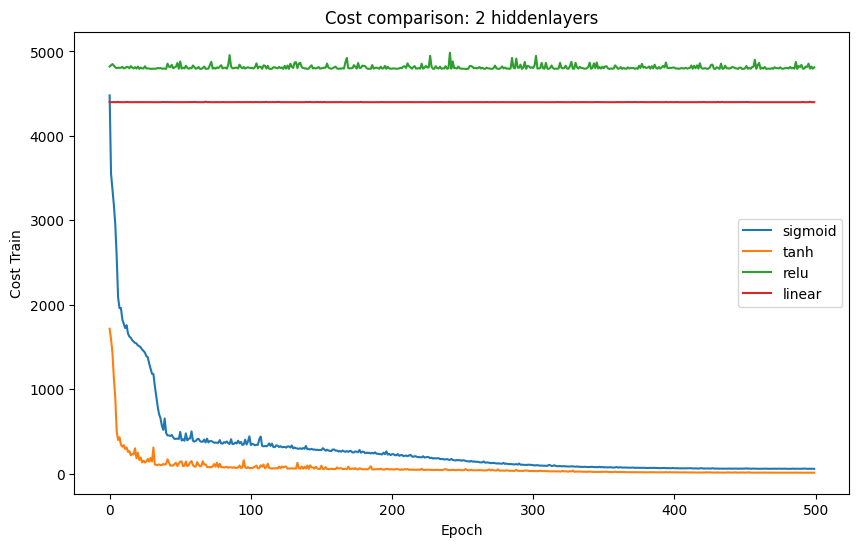

In [342]:
plot_multiple_costs(cost_list, "Cost comparison: 2 hiddenlayers")

### 3 warstwy ukryte

In [267]:
net_mm_l_sigmoid_l3 = Network([1,4,4,4,1], activation_function_type="sigmoid", problem = "regression")
net_mm_l_sigmoid_l3.set_custom_weights([np.array([[0.37553135, 0.2208647 , 0.63159897, 0.9490799 ]]),
 np.array([[0.38135734, 0.1484636 , 0.06687484, 0.6545129 ],
        [0.94178151, 0.51988723, 0.75782658, 0.09524285],
        [0.57478359, 0.64328292, 0.67887638, 0.71914044],
        [0.00123482, 0.29768122, 0.1418534 , 0.11179177]]),
 np.array([[0.7146968 , 0.40319766, 0.51358898, 0.99379366],
        [0.9926051 , 0.12914533, 0.55918468, 0.52852465],
        [0.84158094, 0.45241044, 0.33965858, 0.54009112],
        [0.85868769, 0.81825403, 0.08327351, 0.28686469]]),
 np.array([[0.33985496],
        [0.07431189],
        [0.1225543 ],
        [0.70051122]])])
net_mm_l_sigmoid_l3.generate_biases("zeros")
net_mm_l_sigmoid_l3.train(X_train_mm_l, y_train_mm_l, 100, 0.001, 500, shuffle=True, X_test = X_test_mm_l, Y_test=y_test_mm_l, method="moment", alpha=0.9)

Epoch 0 complete, mse: 5145.192723894879
Epoch 1 complete, mse: 5122.776556838849
Epoch 2 complete, mse: 4670.894149709428
Epoch 3 complete, mse: 3834.3828713865587
Epoch 4 complete, mse: 3587.776842317584
Epoch 5 complete, mse: 3285.6125007693486
Epoch 6 complete, mse: 3136.010496820645
Epoch 7 complete, mse: 2948.651643613765
Epoch 8 complete, mse: 2571.9243715641355
Epoch 9 complete, mse: 2170.661797336306
Epoch 10 complete, mse: 2158.0934143168497
Epoch 11 complete, mse: 2057.864222138495
Epoch 12 complete, mse: 1962.7684532972637
Epoch 13 complete, mse: 1913.4210238390735
Epoch 14 complete, mse: 1835.3731764554343
Epoch 15 complete, mse: 1786.0363976495687
Epoch 16 complete, mse: 1756.4418940784433
Epoch 17 complete, mse: 1711.1299881445009
Epoch 18 complete, mse: 1650.3034685859216
Epoch 19 complete, mse: 1676.2623780106665
Epoch 20 complete, mse: 1557.4854848922273
Epoch 21 complete, mse: 1501.8738159689908
Epoch 22 complete, mse: 1448.7905390628903
Epoch 23 complete, mse: 1402.

In [268]:
net_mm_l_tanh_l3 = Network([1,4,4,4,1], activation_function_type="tanh", problem = "regression")
net_mm_l_tanh_l3.set_custom_weights([np.array([[0.37553135, 0.2208647 , 0.63159897, 0.9490799 ]]),
 np.array([[0.38135734, 0.1484636 , 0.06687484, 0.6545129 ],
        [0.94178151, 0.51988723, 0.75782658, 0.09524285],
        [0.57478359, 0.64328292, 0.67887638, 0.71914044],
        [0.00123482, 0.29768122, 0.1418534 , 0.11179177]]),
 np.array([[0.7146968 , 0.40319766, 0.51358898, 0.99379366],
        [0.9926051 , 0.12914533, 0.55918468, 0.52852465],
        [0.84158094, 0.45241044, 0.33965858, 0.54009112],
        [0.85868769, 0.81825403, 0.08327351, 0.28686469]]),
 np.array([[0.33985496],
        [0.07431189],
        [0.1225543 ],
        [0.70051122]])])
net_mm_l_tanh_l3.generate_biases("zeros")
net_mm_l_tanh_l3.train(X_train_mm_l, y_train_mm_l, 100, 0.001, 500, shuffle=True, X_test = X_test_mm_l, Y_test=y_test_mm_l, method="moment", alpha=0.9)

Epoch 0 complete, mse: 1686.4027775785603
Epoch 1 complete, mse: 1660.2038815984097
Epoch 2 complete, mse: 1646.8611174207763
Epoch 3 complete, mse: 1892.6983593280042
Epoch 4 complete, mse: 1555.7692060852826
Epoch 5 complete, mse: 1473.3758490600258
Epoch 6 complete, mse: 1155.7048631006853
Epoch 7 complete, mse: 1065.589180239295
Epoch 8 complete, mse: 1055.0872462301131
Epoch 9 complete, mse: 987.8851060931341
Epoch 10 complete, mse: 965.2263280663063
Epoch 11 complete, mse: 978.7096655208951
Epoch 12 complete, mse: 919.5990418119042
Epoch 13 complete, mse: 920.3652968850088
Epoch 14 complete, mse: 914.4587837229203
Epoch 15 complete, mse: 908.9892798715946
Epoch 16 complete, mse: 918.7967345200947
Epoch 17 complete, mse: 898.5680625699235
Epoch 18 complete, mse: 936.5223958684448
Epoch 19 complete, mse: 900.8557675038738
Epoch 20 complete, mse: 904.27723729808
Epoch 21 complete, mse: 912.768245028041
Epoch 22 complete, mse: 898.8394464327395
Epoch 23 complete, mse: 896.24849430764

In [319]:
net_mm_l_relu_l3 = Network([1,4,4,4,1], activation_function_type="relu", problem = "regression")
net_mm_l_relu_l3.set_custom_weights([np.array([[0.37553135, 0.2208647 , 0.63159897, 0.9490799 ]]),
 np.array([[0.38135734, 0.1484636 , 0.06687484, 0.6545129 ],
        [0.94178151, 0.51988723, 0.75782658, 0.09524285],
        [0.57478359, 0.64328292, 0.67887638, 0.71914044],
        [0.00123482, 0.29768122, 0.1418534 , 0.11179177]]),
 np.array([[0.7146968 , 0.40319766, 0.51358898, 0.99379366],
        [0.9926051 , 0.12914533, 0.55918468, 0.52852465],
        [0.84158094, 0.45241044, 0.33965858, 0.54009112],
        [0.85868769, 0.81825403, 0.08327351, 0.28686469]]),
 np.array([[0.33985496],
        [0.07431189],
        [0.1225543 ],
        [0.70051122]])])
net_mm_l_relu_l3.generate_biases("zeros")
net_mm_l_relu_l3.train(X_train_mm_l, y_train_mm_l, 100, 0.001, 500, shuffle=True, X_test = X_test_mm_l, Y_test=y_test_mm_l, method="moment", alpha=0.9)

Epoch 0 complete, mse: 5183.690954899578
Epoch 1 complete, mse: 5177.782472963376
Epoch 2 complete, mse: 5211.576807504789
Epoch 3 complete, mse: 5177.866880139731
Epoch 4 complete, mse: 5212.432196584463
Epoch 5 complete, mse: 5183.54190597301
Epoch 6 complete, mse: 5178.184439755169
Epoch 7 complete, mse: 5193.253705206127
Epoch 8 complete, mse: 5245.543609531921
Epoch 9 complete, mse: 5192.942965699527
Epoch 10 complete, mse: 5177.279223650836
Epoch 11 complete, mse: 5204.843977704243
Epoch 12 complete, mse: 5181.478832722273
Epoch 13 complete, mse: 5191.820443600895
Epoch 14 complete, mse: 5177.671585259638
Epoch 15 complete, mse: 5187.126966469368
Epoch 16 complete, mse: 5178.499632493624
Epoch 17 complete, mse: 5187.784850475769
Epoch 18 complete, mse: 5179.26730492424
Epoch 19 complete, mse: 5188.192688615382
Epoch 20 complete, mse: 5197.865658714792
Epoch 21 complete, mse: 5178.569266809441
Epoch 22 complete, mse: 5198.531772807997
Epoch 23 complete, mse: 5184.22284951505
Epoch

In [269]:
net_mm_l_linear_l3 = Network([1,4,4,4,1], activation_function_type="linear", problem = "regression")
net_mm_l_linear_l3.set_custom_weights([np.array([[0.37553135, 0.2208647 , 0.63159897, 0.9490799 ]]),
 np.array([[0.38135734, 0.1484636 , 0.06687484, 0.6545129 ],
        [0.94178151, 0.51988723, 0.75782658, 0.09524285],
        [0.57478359, 0.64328292, 0.67887638, 0.71914044],
        [0.00123482, 0.29768122, 0.1418534 , 0.11179177]]),
 np.array([[0.7146968 , 0.40319766, 0.51358898, 0.99379366],
        [0.9926051 , 0.12914533, 0.55918468, 0.52852465],
        [0.84158094, 0.45241044, 0.33965858, 0.54009112],
        [0.85868769, 0.81825403, 0.08327351, 0.28686469]]),
 np.array([[0.33985496],
        [0.07431189],
        [0.1225543 ],
        [0.70051122]])])
net_mm_l_linear_l3.generate_biases("zeros")
net_mm_l_linear_l3.train(X_train_mm_l, y_train_mm_l, 100, 0.001, 500, shuffle=True, X_test = X_test_mm_l, Y_test=y_test_mm_l, method="moment", alpha=0.9)

Epoch 0 complete, mse: 4418.410940007905
Epoch 1 complete, mse: 4424.939211018629
Epoch 2 complete, mse: 4460.702173236886
Epoch 3 complete, mse: 4403.313001030608
Epoch 4 complete, mse: 4464.869222401116
Epoch 5 complete, mse: 4524.330351751212
Epoch 6 complete, mse: 4480.469421806479
Epoch 7 complete, mse: 4479.828658154787
Epoch 8 complete, mse: 4424.171213546335
Epoch 9 complete, mse: 4510.427378095866
Epoch 10 complete, mse: 4435.462369064443
Epoch 11 complete, mse: 4413.166950295231
Epoch 12 complete, mse: 4418.813705605766
Epoch 13 complete, mse: 4433.591626716418
Epoch 14 complete, mse: 4459.820701857479
Epoch 15 complete, mse: 4417.42850611781
Epoch 16 complete, mse: 4459.565636195672
Epoch 17 complete, mse: 4420.071025832519
Epoch 18 complete, mse: 4450.757698253401
Epoch 19 complete, mse: 4414.285379262894
Epoch 20 complete, mse: 4433.152975118955
Epoch 21 complete, mse: 4400.7435416057615
Epoch 22 complete, mse: 4495.55791733939
Epoch 23 complete, mse: 4406.016122347827
Epo

In [320]:
sigm_l3 = make_df_of_costs(net_mm_l_sigmoid_l3.cost_history)
tanh_l3 = make_df_of_costs(net_mm_l_tanh_l3.cost_history)
relu_l3 = make_df_of_costs(net_mm_l_relu_l3.cost_history)
linear_l3 = make_df_of_costs(net_mm_l_linear_l3.cost_history)
cost_list = [(sigm_l3, 'sigmoid'), (tanh_l3, 'tanh'),(relu_l3, 'relu'),(linear_l3, 'linear')]

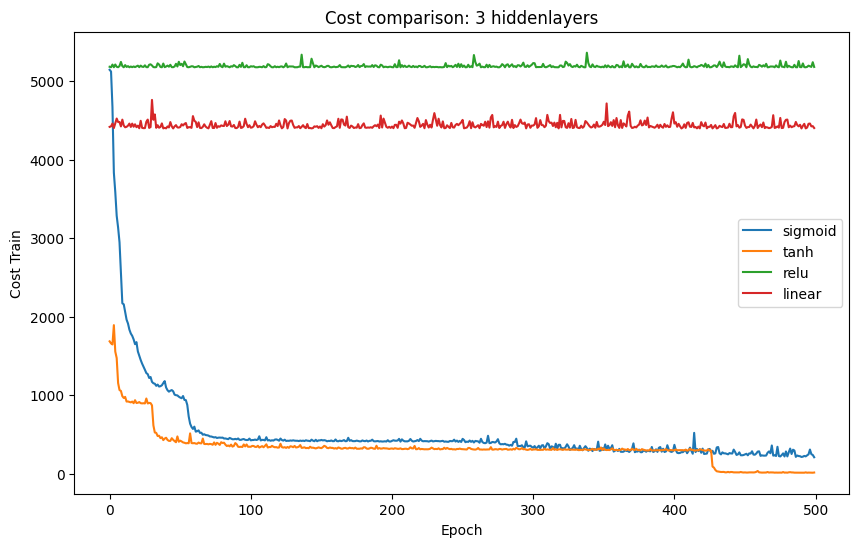

In [321]:
plot_multiple_costs(cost_list, "Cost comparison: 3 hiddenlayers")

### Podsumowanie MSE

In [343]:
print("Podsumowanie MSE dla każdej z architektur:\n------------------------------------------------------------")
print("---------- 1 warstwa ukryta: ---------- ")
print("| sigmoid:", 114.92,"| tanh:",63.74,"| relu:",2797.34, "| linear:", 4442.99,"|")
print("----------  2 warstwy ukryte: ---------- ")
print("| sigmoid:", 50.41,"| tanh:",5.55,"| relu:",4824.08, "| linear:", 4433.59,"|")
print("----------  3 warstwa ukryte: ---------- ")
print("| sigmoid:", 218.60,"| tanh:",10.32,"| relu:",5228.50, "| linear:", 4438.95,"|")

Podsumowanie MSE dla każdej z architektur:
------------------------------------------------------------
---------- 1 warstwa ukryta: ---------- 
| sigmoid: 114.92 | tanh: 63.74 | relu: 2797.34 | linear: 4442.99 |
----------  2 warstwy ukryte: ---------- 
| sigmoid: 50.41 | tanh: 5.55 | relu: 4824.08 | linear: 4433.59 |
----------  3 warstwa ukryte: ---------- 
| sigmoid: 218.6 | tanh: 10.32 | relu: 5228.5 | linear: 4438.95 |


Widzimy zatem, że ze względu na MSE na zbiorze testowym, najlepsze zestawy to:
 - 2 warstwy ukryte [7,7], funkcja aktywacji: tanh, 
 - 3 warstwy ukryte [4,4,4], funkcja aktywacji: tanh

## Skuteczność najlepszych 2 zestawów

##### Zbiór steps-large

In [289]:
net_st_l_1 = Network([1,7,7,1], activation_function_type="tanh", problem = "regression")
net_st_l_1.generate_weights("uniform")
net_st_l_1.generate_biases("zeros")
net_st_l_1.train(X_train_st_l, y_train_st_l, 100, 0.001, 500, shuffle=True, X_test = X_test_st_l, Y_test=y_test_st_l, method="moment", alpha=0.9)

Epoch 0 complete, mse: 543.0998658142578
Epoch 1 complete, mse: 431.1060874743831
Epoch 2 complete, mse: 399.1472329389073
Epoch 3 complete, mse: 337.58232004844945
Epoch 4 complete, mse: 327.3730593950353
Epoch 5 complete, mse: 315.75428855966965
Epoch 6 complete, mse: 292.69710784021504
Epoch 7 complete, mse: 285.5940747980478
Epoch 8 complete, mse: 249.04874261910533
Epoch 9 complete, mse: 238.71047608731422
Epoch 10 complete, mse: 203.73309237536685
Epoch 11 complete, mse: 195.40430702844998
Epoch 12 complete, mse: 166.69517518330227
Epoch 13 complete, mse: 159.77428124107797
Epoch 14 complete, mse: 157.49539509658604
Epoch 15 complete, mse: 168.1252252725557
Epoch 16 complete, mse: 149.94123210396137
Epoch 17 complete, mse: 147.3856517135395
Epoch 18 complete, mse: 145.85296731040265
Epoch 19 complete, mse: 146.8727969084393
Epoch 20 complete, mse: 139.6291058542082
Epoch 21 complete, mse: 141.04140185049843
Epoch 22 complete, mse: 129.7701777349146
Epoch 23 complete, mse: 129.891

In [332]:
print("MSE test steps-large - zestaw 1: ", 17.80337314690982)

MSE test steps-large - zestaw 1:  17.80337314690982


In [290]:
net_st_l_2 = Network([1,4,4,4,1], activation_function_type="tanh", problem = "regression")
net_st_l_2.generate_weights("uniform")
net_st_l_2.generate_biases("zeros")
net_st_l_2.train(X_train_st_l, y_train_st_l, 100, 0.001, 500, shuffle=True, X_test = X_test_st_l, Y_test=y_test_st_l, method="moment", alpha=0.9)

Epoch 0 complete, mse: 506.1144062834917
Epoch 1 complete, mse: 500.84686928746754
Epoch 2 complete, mse: 496.0469798886058
Epoch 3 complete, mse: 513.0302404932992
Epoch 4 complete, mse: 518.6144771312414
Epoch 5 complete, mse: 491.4320197118176
Epoch 6 complete, mse: 618.9932498585406
Epoch 7 complete, mse: 498.1464017055041
Epoch 8 complete, mse: 588.8934137852385
Epoch 9 complete, mse: 506.1997841917772
Epoch 10 complete, mse: 470.34742011280923
Epoch 11 complete, mse: 477.83457228596006
Epoch 12 complete, mse: 448.6232808778324
Epoch 13 complete, mse: 454.1064622993972
Epoch 14 complete, mse: 470.3171531717431
Epoch 15 complete, mse: 450.418542650579
Epoch 16 complete, mse: 435.8295711486183
Epoch 17 complete, mse: 440.90035699105374
Epoch 18 complete, mse: 433.66764423604457
Epoch 19 complete, mse: 412.76150806143335
Epoch 20 complete, mse: 380.8104228232741
Epoch 21 complete, mse: 327.43011822412996
Epoch 22 complete, mse: 278.7189849745964
Epoch 23 complete, mse: 227.2563362166

In [333]:
print("MSE test steps-large - zestaw 2: ", 73.83116204354711)

MSE test steps-large - zestaw 2:  73.83116204354711


##### Zbiór rings5-regular

In [303]:
net_r5_r_1 = Network([2,7,7,5], "tanh", problem = "classification", last_layer_function="softmax")
net_r5_r_1.generate_weights("he")
net_r5_r_1.generate_biases("zeros")
net_r5_r_1.train(X_train_r5_r, y_train_r5_r_enc, 100, 0.01, 1000, shuffle=False, X_test = X_test_r5_r, Y_test=y_test_r5_r_enc, method="RMSProp", alpha=0.9)

Epoch 0 complete, Fscore: [0.00793651 0.03861004 0.35       0.         0.52619325], Fscore_mean: 0.18454795890185877
Epoch 1 complete, Fscore: [0.         0.04460967 0.35091743 0.         0.52619325], Fscore_mean: 0.18434406891658345
Epoch 2 complete, Fscore: [0.         0.44844125 0.01960784 0.00796813 0.52619325], Fscore_mean: 0.20044209311848804
Epoch 3 complete, Fscore: [0.17508418 0.45443787 0.         0.         0.52680653], Fscore_mean: 0.23126571434263746
Epoch 4 complete, Fscore: [0.19195046 0.44823386 0.         0.         0.52803738], Fscore_mean: 0.23364434174376
Epoch 5 complete, Fscore: [0.06206897 0.44755245 0.         0.         0.53051643], Fscore_mean: 0.2080275689989143
Epoch 6 complete, Fscore: [0.05633803 0.45265589 0.         0.         0.53176471], Fscore_mean: 0.20815172463937276
Epoch 7 complete, Fscore: [0.03584229 0.45517241 0.         0.07885305 0.54987835], Fscore_mean: 0.2239492199587358
Epoch 8 complete, Fscore: [0.02158273 0.45517241 0.00796813 0.0893470

In [334]:
print("Fscore test rings5-regular - zestaw 1: ", 0.7633794311539064)

Fscore test rings5-regular - zestaw 1:  0.7633794311539064


In [304]:
net_r5_r_2 = Network([2,4,4,4,5], "tanh", problem = "classification", last_layer_function="softmax")
net_r5_r_2.generate_weights("he")
net_r5_r_2.generate_biases("zeros")
net_r5_r_2.train(X_train_r5_r, y_train_r5_r_enc, 100, 0.01, 1000, shuffle=False, X_test = X_test_r5_r, Y_test=y_test_r5_r_enc, method="RMSProp", alpha=0.9)

Epoch 0 complete, Fscore: [0.40358744 0.         0.         0.         0.52680653], Fscore_mean: 0.18607879415054301
Epoch 1 complete, Fscore: [0.40358744 0.         0.         0.         0.52680653], Fscore_mean: 0.18607879415054301
Epoch 2 complete, Fscore: [0.40358744 0.         0.         0.         0.52680653], Fscore_mean: 0.18607879415054301
Epoch 3 complete, Fscore: [0.4609475  0.         0.05194805 0.         0.52680653], Fscore_mean: 0.20794041639112062
Epoch 4 complete, Fscore: [0.48322148 0.06896552 0.20786517 0.         0.52680653], Fscore_mean: 0.2573717378194599
Epoch 5 complete, Fscore: [0.48543689 0.35978836 0.2720403  0.         0.52742124], Fscore_mean: 0.3289373584264116
Epoch 6 complete, Fscore: [0.16140351 0.49185185 0.29099307 0.         0.52742124], Fscore_mean: 0.2943339338180255
Epoch 7 complete, Fscore: [0.16666667 0.4826546  0.29478458 0.         0.52680653], Fscore_mean: 0.2941824748547438
Epoch 8 complete, Fscore: [0.1875     0.46604938 0.3032967  0.      

In [335]:
print("Fscore test rings5-regular - zestaw 2: ", 0.5076734485587648)

Fscore test rings5-regular - zestaw 2:  0.5076734485587648


##### Zbiór rings3-regular

In [353]:
net_r3_r_1 = Network([2,7,7,3], "tanh", problem = "classification", last_layer_function="softmax")
net_r3_r_1.generate_weights("he")
net_r3_r_1.generate_biases("zeros")
net_r3_r_1.train(X_train_r3_r, y_train_r3_r_enc, 100, 0.01, 1000, shuffle=False, X_test = X_test_r3_r, Y_test=y_test_r3_r_enc, method="RMSProp", alpha=0.9)

Epoch 0 complete, Fscore: [0.38353765 0.21393841 0.43029815], Fscore_mean: 0.3425914038550735
Epoch 1 complete, Fscore: [0.32973503 0.39083233 0.49652778], Fscore_mean: 0.4056983800771097
Epoch 2 complete, Fscore: [0.31397849 0.45286885 0.53747715], Fscore_mean: 0.434774831721037
Epoch 3 complete, Fscore: [0.15363512 0.53690037 0.56276327], Fscore_mean: 0.4177662514488348
Epoch 4 complete, Fscore: [0.25876663 0.47843137 0.54640069], Fscore_mean: 0.4278662309171697
Epoch 5 complete, Fscore: [0.03864734 0.57119205 0.51238258], Fscore_mean: 0.3740739916558719
Epoch 6 complete, Fscore: [0.22493888 0.46561886 0.5257732 ], Fscore_mean: 0.4054436438975726
Epoch 7 complete, Fscore: [0.26222222 0.43763214 0.52686308], Fscore_mean: 0.40890581415026217
Epoch 8 complete, Fscore: [0.11182109 0.56560717 0.48299913], Fscore_mean: 0.38680912879551316
Epoch 9 complete, Fscore: [0.07692308 0.52543786 0.50872818], Fscore_mean: 0.3703630404538684
Epoch 10 complete, Fscore: [0.15128593 0.58408532 0.525    

In [356]:
print("Fscore test rings3-regular - zestaw 1: ", 0.8489927902815868)

Fscore test rings3-regular - zestaw 1:  0.8489927902815868


In [358]:
net_r3_r_2 = Network([2,4,4,4,3], "tanh", problem = "classification", last_layer_function="softmax")
net_r3_r_2.generate_weights("he")
net_r3_r_2.generate_biases("zeros")
net_r3_r_2.train(X_train_r3_r, y_train_r3_r_enc, 100, 0.01, 1000, shuffle=False, X_test = X_test_r3_r, Y_test=y_test_r3_r_enc, method="RMSProp", alpha=0.9)

Epoch 0 complete, Fscore: [0.40983607 0.4197731  0.11721612], Fscore_mean: 0.31560842613795825
Epoch 1 complete, Fscore: [0.31516353 0.41666667 0.46638298], Fscore_mean: 0.399404391211953
Epoch 2 complete, Fscore: [0.29617834 0.51423786 0.50254669], Fscore_mean: 0.4376542963997827
Epoch 3 complete, Fscore: [0.03891051 0.48349962 0.51225697], Fscore_mean: 0.3448890319673857
Epoch 4 complete, Fscore: [0.         0.57513349 0.52481077], Fscore_mean: 0.36664808374588914
Epoch 5 complete, Fscore: [0.         0.58408408 0.54623288], Fscore_mean: 0.3767723202654709
Epoch 6 complete, Fscore: [0.         0.58470765 0.54545455], Fscore_mean: 0.37672073054381894
Epoch 7 complete, Fscore: [0.         0.61746988 0.5704526 ], Fscore_mean: 0.39597416137650515
Epoch 8 complete, Fscore: [0.0039604  0.62509391 0.57044674], Fscore_mean: 0.39983368192830193
Epoch 9 complete, Fscore: [0.         0.61829176 0.56923077], Fscore_mean: 0.39584084345989107
Epoch 10 complete, Fscore: [0.00788955 0.60757576 0.560

In [359]:
print("Fscore test rings3-regular - zestaw 2: ", 0.6860232045170638)

Fscore test rings3-regular - zestaw 2:  0.6860232045170638


### Podsumowanie

Funkcją aktywacji która radziła sobie najlepiej dla zbioru *multimodal-large* była tanh. Niezależnie od liczby warstw ukrytych zawsze dawała nam najlepszy wynik.
Funkcja sigmoidalna radziła sobie niewiele gorzej od niej, wciąż dając zadowalające wyniki.
Funkcja relu nie poradziła sobie dobrze. Przy jej używaniu, w jednym z zestawów MSE na początku trochę spadało, jednak potem utrzymywało praktycznie stałą wartość. W pozostałych przypadkach MSE było praktycznie stałe.
Funkcja liniowa poradziła sobie zdecydowanie najgorzej. MSE od samego początku było praktycznie stałe, podobnie jak w przypadku funkcji relu.


Architekturą która dała najlepsze wyniki, była architektura z 2 warstwami ukrytymi, w której umieściłam po 7 na każdej z warstw ukrytych. Architektury z 1 oraz z 3 warstwami ukrytymi radziły sobie gorzej, jednak która z nich najgorzej, to zależy od użytej funkcji aktywacji.

W związku z powyższym, do tematu regresji najlepiej nadaje się funkcja aktywacji tanh bądź sigmoid. Funkcje relu oraz liniowa nie są warte używania.